# <font color = 'red'> Strategy </font>
### Bollinger bands are comprised of a simple moving average along with upper and lower bands (typically 2 STDDEV away). The bands widen and narrow as the volatility of the underlying asset changes. 

# <font color = 'red'> Configuration </font>

In [2]:
!pip3 install ta  


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# <font color = 'red'> Indicator Imports </font>

In [1]:
#Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

#Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

/Users/zuohui/opt/anaconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# <font color = 'red'> MAANG stocks and Period</font>

In [3]:
meta = 'META'
amazon = "AMZN"
apple = "AAPL"
netflix = 'NFLX'
google = 'GOOGL'

stockList = {meta : {}, amazon: {}, apple: {}, netflix: {}, google: {}}
stockData = {}
weight = 0.2

start = '2015-01-01'
end = '2019-12-31'

# <font color = 'red'> Plot graphs for stocklist to check</font>

Text(0.5, 1.0, 'stock close price')

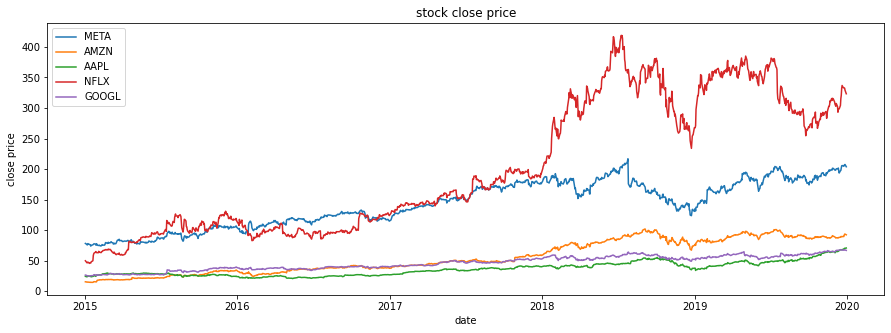

In [5]:
fig = plt.figure(figsize=(15, 5))
for stock in stockList.keys():
	hist_stock = yf.Ticker(stock).history(start = start, end = end)
	stockList[stock]['info'] = hist_stock
	plt.plot(hist_stock.index, hist_stock['Close'], label=f"{stock}")
	plt.legend()

plt.xlabel('date')
plt.ylabel('close price')
plt.title(f'stock close price')

<hr>

# MACD 200EMA

[*********************100%%**********************]  1 of 1 completed
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

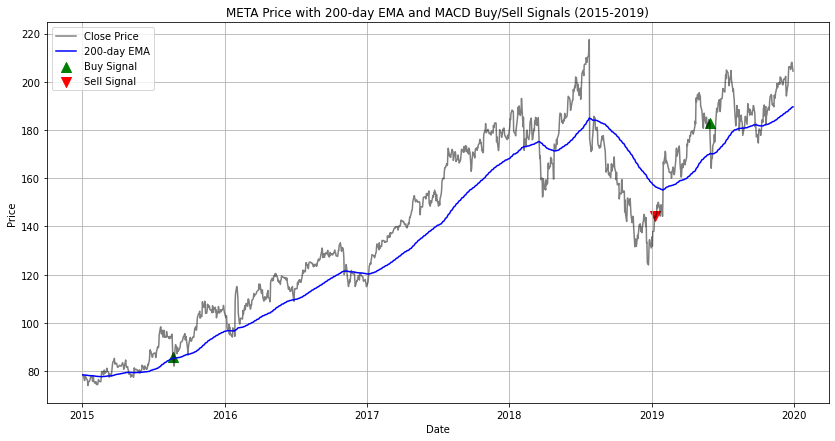


Final Cumulative Returns for META:
Strategy Return: 42.39%
Buy & Hold Return: 160.56%


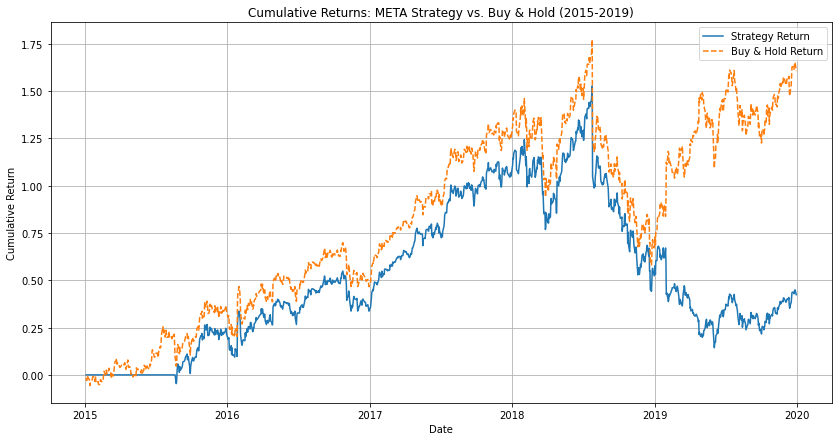

[*********************100%%**********************]  1 of 1 completed
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

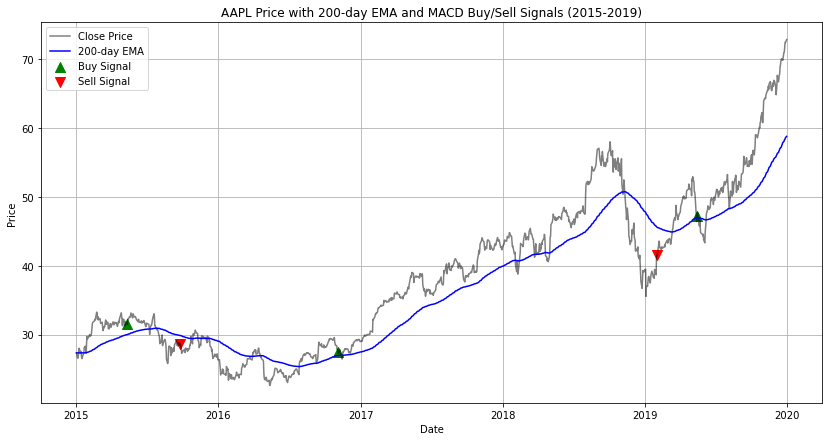


Final Cumulative Returns for AAPL:
Strategy Return: 81.16%
Buy & Hold Return: 166.64%


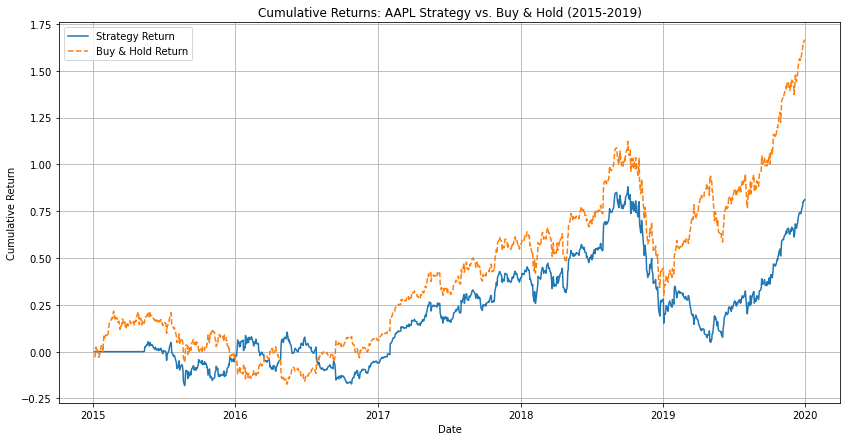

[*********************100%%**********************]  1 of 1 completed
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = -1  # Go short
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

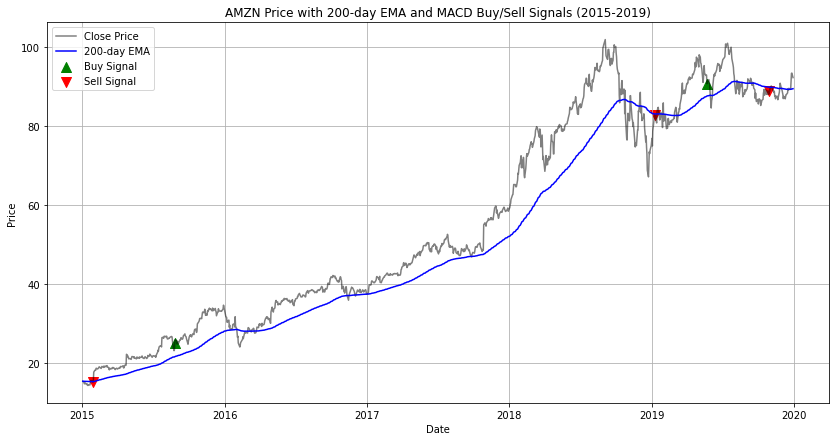


Final Cumulative Returns for AMZN:
Strategy Return: 55.07%
Buy & Hold Return: 498.63%


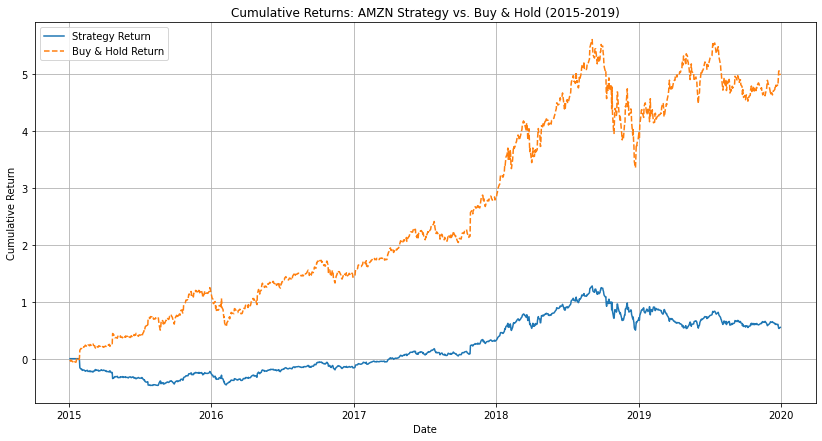

[*********************100%%**********************]  1 of 1 completed
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

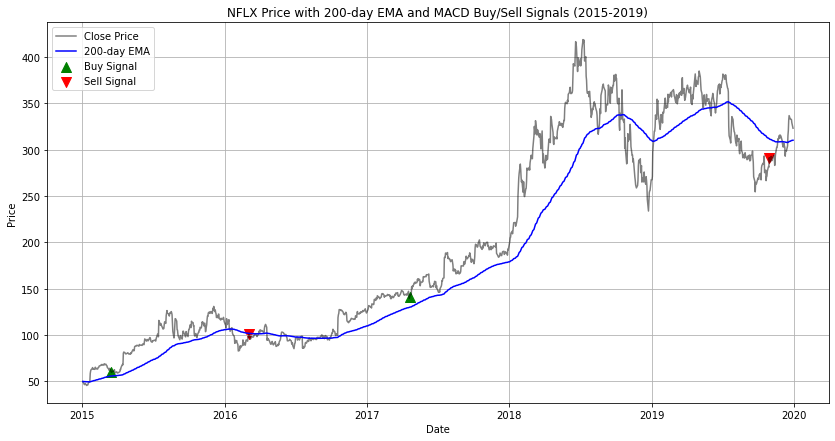


Final Cumulative Returns for NFLX:
Strategy Return: 91.35%
Buy & Hold Return: 548.58%


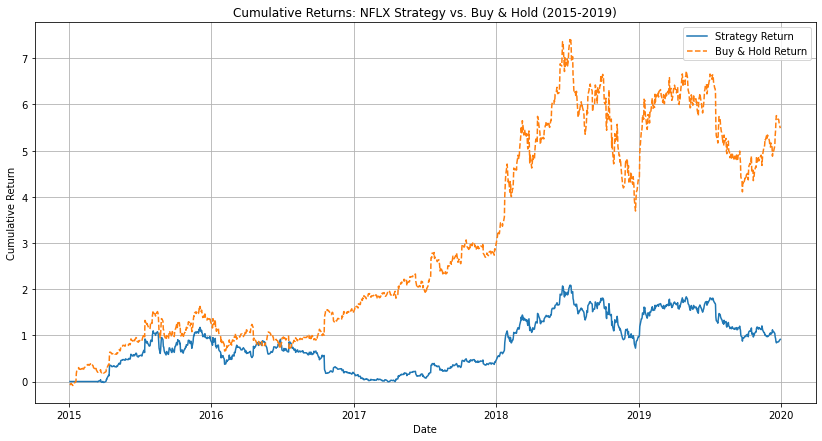

[*********************100%%**********************]  1 of 1 completed
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3199359783.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

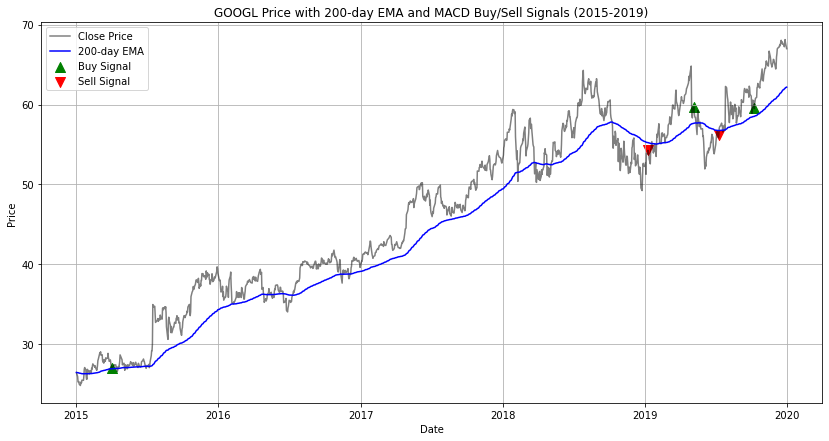


Final Cumulative Returns for GOOGL:
Strategy Return: 75.92%
Buy & Hold Return: 152.99%


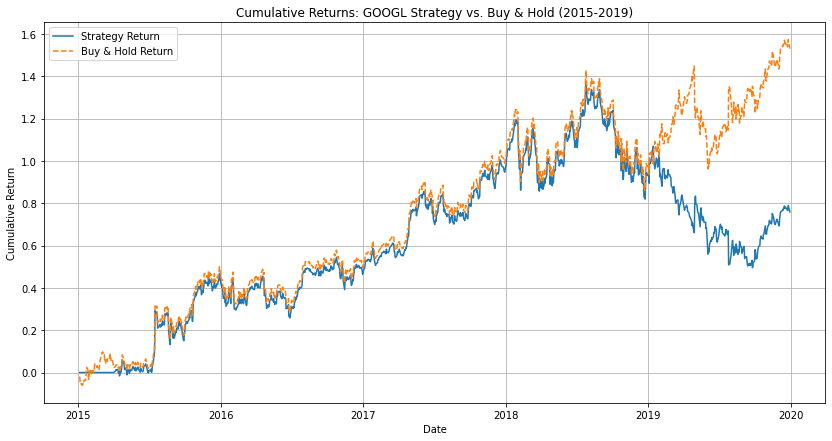

In [34]:
# MAANG stocks list
stocks = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2015-01-01'
end_date = '2019-12-31'

# Define the strategy function
def strategy(stock):
    # Download stock data from Yahoo Finance
    data = yf.download(stock, start=start_date, end=end_date)
    
    # Calculate the 200-day EMA
    data['EMA_200'] = data['Close'].ewm(span=150, adjust=False).mean()
    
    # Calculate the MACD (12, 26, 9)
    exp12 = data['Close'].ewm(span=12, adjust=False).mean()
    exp26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp12 - exp26
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Initialize position
    data['Position'] = 0  # 1 for long, -1 for short

    # Signal generation based on EMA and MACD
    for i in range(1, len(data)):
        # Buy signal: Price above 200-day EMA and MACD crosses below zero line
        if (data['Close'].iloc[i] > data['EMA_200'].iloc[i]) and (data['MACD'].iloc[i] < 0) and (data['MACD'].iloc[i-1] >= 0):
            data['Position'].iloc[i] = 1  # Go long

        # Sell signal: Price below 200-day EMA and MACD crosses above zero line
        elif (data['Close'].iloc[i] < data['EMA_200'].iloc[i]) and (data['MACD'].iloc[i] > 0) and (data['MACD'].iloc[i-1] <= 0):
            data['Position'].iloc[i] = -1  # Go short

        # Maintain previous position
        else:
            data['Position'].iloc[i] = data['Position'].iloc[i-1]

    # Calculate daily returns
    data['Market_Return'] = data['Close'].pct_change()

    # Calculate strategy returns
    data['Strategy_Return'] = data['Position'].shift(1) * data['Market_Return']

    # Cumulative returns
    data['Cumulative_Strategy_Return'] = (data['Strategy_Return'] + 1).cumprod() - 1
    data['Cumulative_Market_Return'] = (data['Market_Return'] + 1).cumprod() - 1

    # Visualization of price, 200-day EMA, and buy/sell signals
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', color='black', alpha=0.5)
    plt.plot(data['EMA_200'], label='200-day EMA', color='blue')

    # Plot Buy signals (MACD cross below zero and price above 200 EMA)
    buy_signals = data[(data['Position'] == 1) & (data['Position'].shift(1) != 1)]
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100)

    # Plot Sell signals (MACD cross above zero and price below 200 EMA)
    sell_signals = data[(data['Position'] == -1) & (data['Position'].shift(1) != -1)]
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100)

    plt.title(f'{stock} Price with 200-day EMA and MACD Buy/Sell Signals (2015-2019)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Final cumulative returns for both strategies
    final_strategy_return = data['Cumulative_Strategy_Return'].iloc[-1]
    final_market_return = data['Cumulative_Market_Return'].iloc[-1]

    print(f"\nFinal Cumulative Returns for {stock}:")
    print(f"Strategy Return: {final_strategy_return:.2%}")
    print(f"Buy & Hold Return: {final_market_return:.2%}")

    # Plot cumulative returns
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Cumulative_Strategy_Return'], label='Strategy Return')
    plt.plot(data.index, data['Cumulative_Market_Return'], label='Buy & Hold Return', linestyle='--')
    plt.title(f'Cumulative Returns: {stock} Strategy vs. Buy & Hold (2015-2019)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()

# Run the strategy for each MAANG stock
for stock in stocks:
    strategy(stock)


## Trading Strategy Class

In [39]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

class TradingStrategy:
    def __init__(self, stock, start_date, end_date):
        self.stock = stock
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.performance_metrics = {}

        # Download stock data from Yahoo Finance
        self._download_data()

    def _download_data(self):
        """Downloads stock data."""
        self.data = yf.download(self.stock, start=self.start_date, end=self.end_date)
    
    def calculate_indicators(self):
        """Calculate the 200-day EMA and MACD indicators."""
        self.data['EMA_200'] = self.data['Close'].ewm(span=200, adjust=False).mean()

        exp12 = self.data['Close'].ewm(span=12, adjust=False).mean()
        exp26 = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = exp12 - exp26
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

    def generate_signals(self):
        """Generate buy and sell signals based on MACD and 200-day EMA."""
        self.data['Position'] = 0  # 1 for long, -1 for short

        for i in range(1, len(self.data)):
            if (self.data['Close'].iloc[i] > self.data['EMA_200'].iloc[i]) and (self.data['MACD'].iloc[i] < 0) and (self.data['MACD'].iloc[i-1] >= 0):
                self.data['Position'].iloc[i] = 1  # Go long
            elif (self.data['Close'].iloc[i] < self.data['EMA_200'].iloc[i]) and (self.data['MACD'].iloc[i] > 0) and (self.data['MACD'].iloc[i-1] <= 0):
                self.data['Position'].iloc[i] = -1  # Go short
            else:
                self.data['Position'].iloc[i] = self.data['Position'].iloc[i-1]

    def calculate_returns(self):
        """Calculate strategy and market returns."""
        self.data['Market_Return'] = self.data['Close'].pct_change()
        self.data['Strategy_Return'] = self.data['Position'].shift(1) * self.data['Market_Return']
        self.data['Cumulative_Strategy_Return'] = (self.data['Strategy_Return'] + 1).cumprod() - 1
        self.data['Cumulative_Market_Return'] = (self.data['Market_Return'] + 1).cumprod() - 1
    
    def cumulative_return(self):
        """Calculate the final cumulative return of the strategy and the market."""
        final_strategy_return = self.data['Cumulative_Strategy_Return'].iloc[-1]
        final_market_return = self.data['Cumulative_Market_Return'].iloc[-1]
        self.performance_metrics['Cumulative Strategy Return'] = final_strategy_return
        self.performance_metrics['Cumulative Market Return'] = final_market_return
        return final_strategy_return, final_market_return

    def sharpe_ratio(self, risk_free_rate=0.0):
        """Calculate the Sharpe ratio of the strategy."""
        excess_return = self.data['Strategy_Return'] - risk_free_rate / 252
        sharpe_ratio = np.sqrt(252) * excess_return.mean() / excess_return.std()
        self.performance_metrics['Sharpe Ratio'] = sharpe_ratio
        return sharpe_ratio

    def sortino_ratio(self, risk_free_rate=0.0):
        """Calculate the Sortino ratio of the strategy."""
        excess_return = self.data['Strategy_Return'] - risk_free_rate / 252
        negative_return = self.data['Strategy_Return'][self.data['Strategy_Return'] < 0]
        downside_deviation = np.std(negative_return) * np.sqrt(252)
        sortino_ratio = (excess_return.mean() * 252) / downside_deviation
        self.performance_metrics['Sortino Ratio'] = sortino_ratio
        return sortino_ratio

    def treynor_ratio(self, beta, risk_free_rate=0.0):
        """Calculate the Treynor ratio of the strategy."""
        excess_return = self.data['Strategy_Return'] - risk_free_rate / 252
        treynor_ratio = (excess_return.mean() * 252) / beta
        self.performance_metrics['Treynor Ratio'] = treynor_ratio
        return treynor_ratio

    def max_drawdown(self):
        """Calculate the maximum drawdown of the strategy."""
        cumulative = (self.data['Strategy_Return'] + 1).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_drawdown = drawdown.min()
        self.performance_metrics['Max Drawdown'] = max_drawdown
        return max_drawdown

    def tracking_error(self):
        """Calculate the tracking error of the strategy vs. the benchmark (buy & hold)."""
        active_return = self.data['Strategy_Return'] - self.data['Market_Return']
        tracking_error = np.std(active_return) * np.sqrt(252)
        self.performance_metrics['Tracking Error'] = tracking_error
        return tracking_error

    def information_ratio(self):
        """Calculate the information ratio of the strategy vs. the benchmark (buy & hold)."""
        active_return = self.data['Strategy_Return'] - self.data['Market_Return']
        information_ratio = (active_return.mean() * 252) / self.tracking_error()
        self.performance_metrics['Information Ratio'] = information_ratio
        return information_ratio

    def visualize_signals(self):
        """Plot price, 200-day EMA, and buy/sell signals."""
        plt.figure(figsize=(14, 7))
        plt.plot(self.data['Close'], label='Close Price', color='black', alpha=0.5)
        plt.plot(self.data['EMA_200'], label='200-day EMA', color='blue')

        # Plot Buy signals
        buy_signals = self.data[(self.data['Position'] == 1) & (self.data['Position'].shift(1) != 1)]
        plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100)

        # Plot Sell signals
        sell_signals = self.data[(self.data['Position'] == -1) & (self.data['Position'].shift(1) != -1)]
        plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100)

        plt.title(f'{self.stock} Price with 200-day EMA and MACD Buy/Sell Signals')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_cumulative_returns(self):
        """Plot cumulative returns of the strategy vs. buy and hold."""
        plt.figure(figsize=(14, 7))
        plt.plot(self.data.index, self.data['Cumulative_Strategy_Return'], label='Strategy Return')
        plt.plot(self.data.index, self.data['Cumulative_Market_Return'], label='Buy & Hold Return', linestyle='--')
        plt.title(f'Cumulative Returns: {self.stock} Strategy vs. Buy & Hold')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid()
        plt.show()

    def summary(self):
        """Print a summary of performance metrics."""
        print(f"Performance Summary for {self.stock}:")
        for metric, value in self.performance_metrics.items():
            print(f"{metric}: {value:.2%}")



[*********************100%%**********************]  1 of 1 completed
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = self.data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

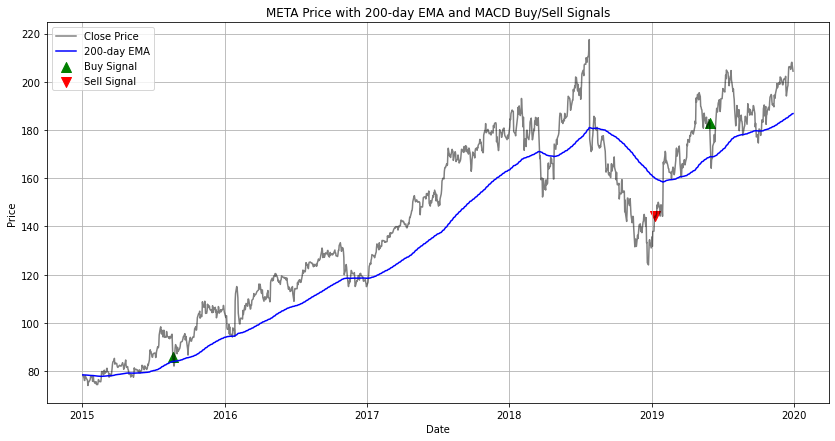

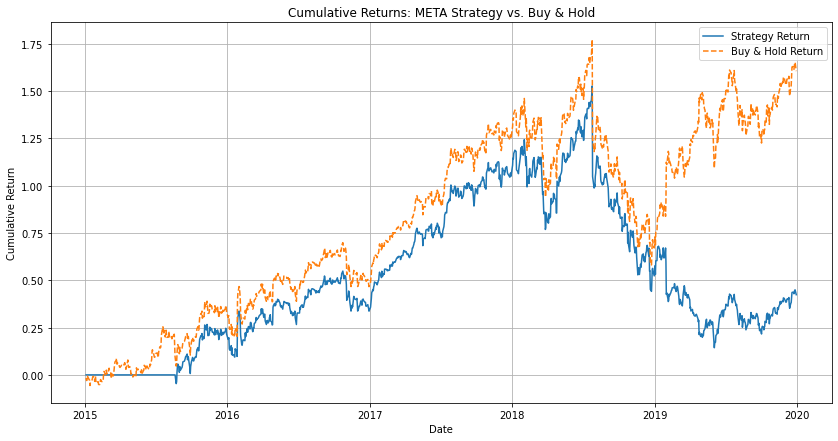

[*********************100%%**********************]  1 of 1 completed

Performance Summary for META:
Cumulative Strategy Return: 42.39%
Cumulative Market Return: 160.56%
Sharpe Ratio: 39.97%
Sortino Ratio: 44.52%
Treynor Ratio: 8.97%
Max Drawdown: -54.76%
Tracking Error: 18.80%
Information Ratio: -66.35%



/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = self.data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

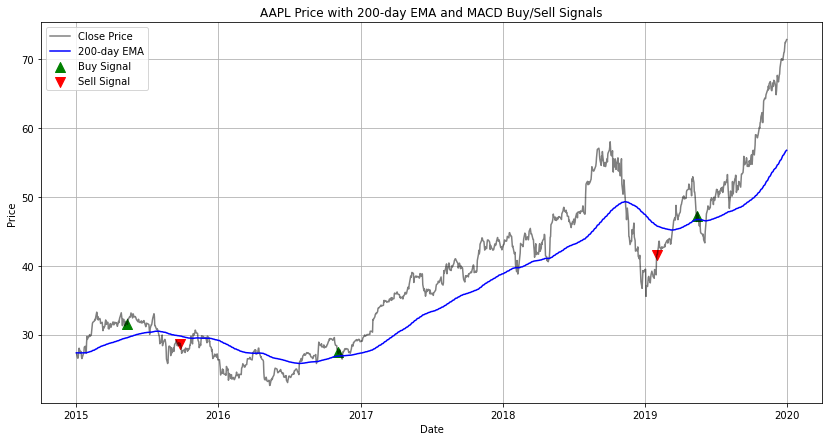

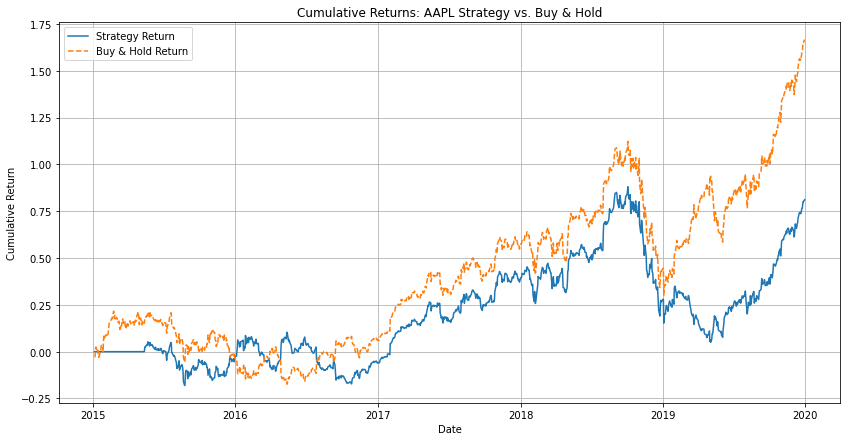

[*********************100%%**********************]  1 of 1 completed

Performance Summary for AAPL:
Cumulative Strategy Return: 81.16%
Cumulative Market Return: 166.64%
Sharpe Ratio: 61.82%
Sortino Ratio: 80.16%
Treynor Ratio: 12.33%
Max Drawdown: -44.18%
Tracking Error: 26.68%
Information Ratio: -29.94%



/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = self.data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = -1  # Go short
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

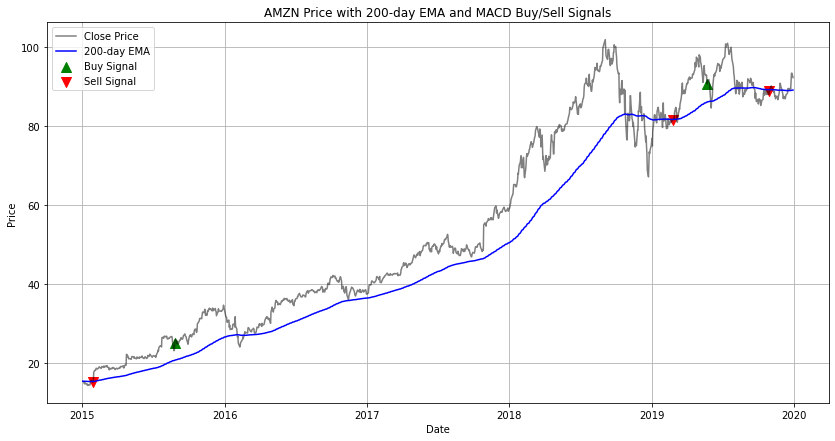

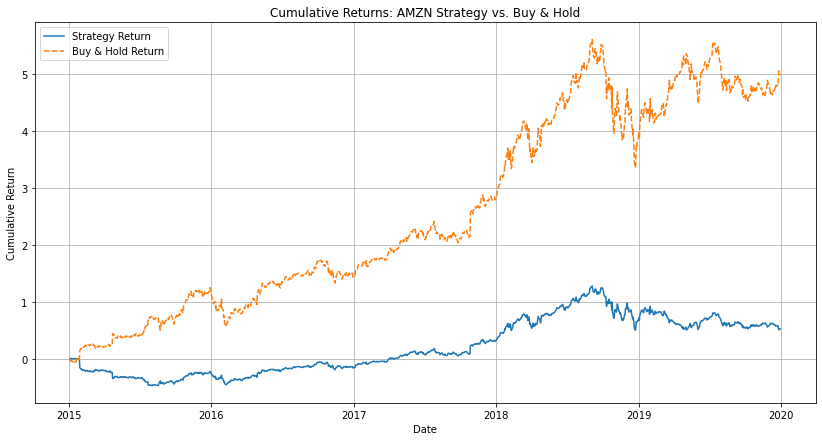

[*********************100%%**********************]  1 of 1 completed

Performance Summary for AMZN:
Cumulative Strategy Return: 52.67%
Cumulative Market Return: 498.63%
Sharpe Ratio: 43.79%
Sortino Ratio: 53.18%
Treynor Ratio: 10.65%
Max Drawdown: -47.15%
Tracking Error: 27.97%
Information Ratio: -97.89%



/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = self.data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

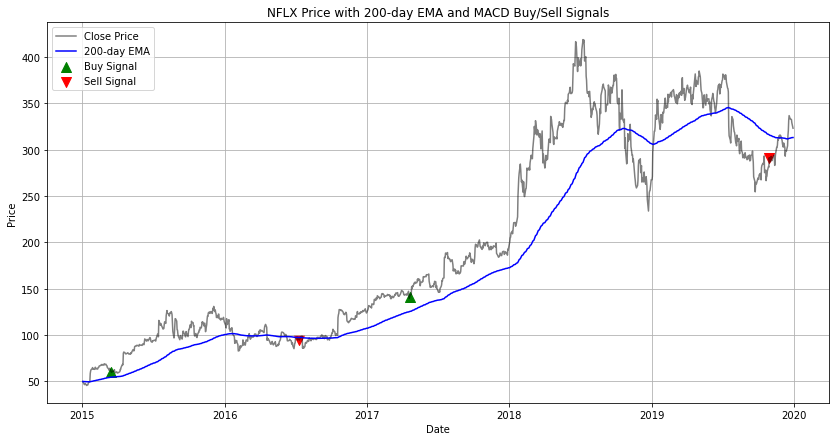

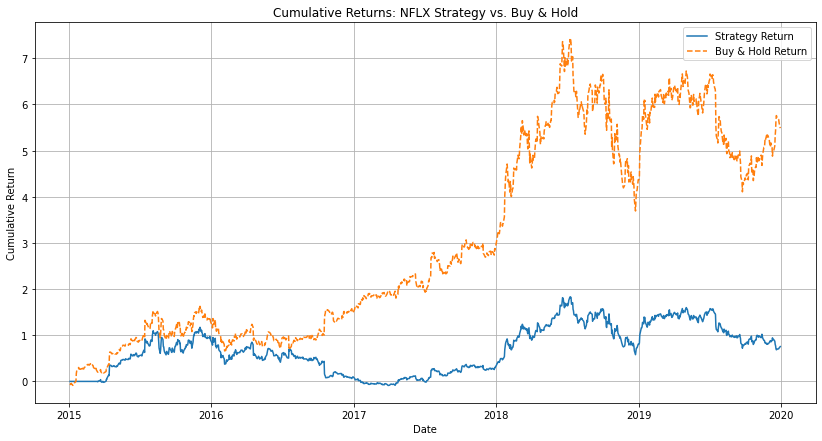

[*********************100%%**********************]  1 of 1 completed

Performance Summary for NFLX:
Cumulative Strategy Return: 75.45%
Cumulative Market Return: 548.58%
Sharpe Ratio: 48.02%
Sortino Ratio: 67.68%
Treynor Ratio: 16.23%
Max Drawdown: -58.04%
Tracking Error: 31.29%
Information Ratio: -85.12%



/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = self.data['Position'].iloc[i-1]
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'].iloc[i] = 1  # Go long
/var/folders/t6/dr1hzlrj5c95vvg2b5zrsv_m0000gn/T/ipykernel_37846/3940500924.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

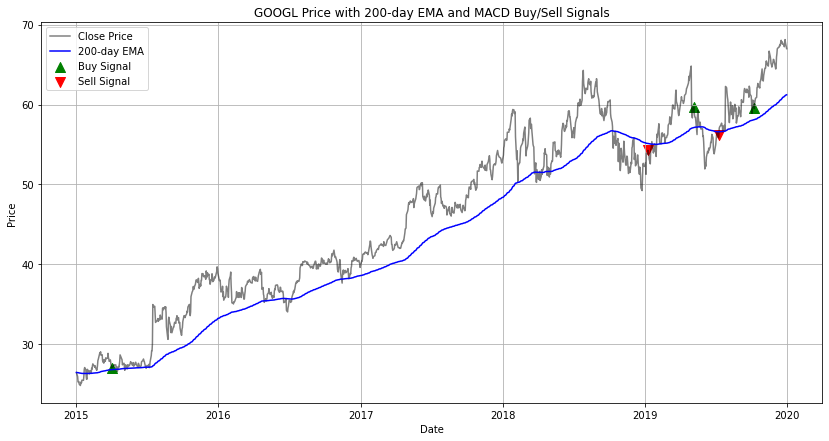

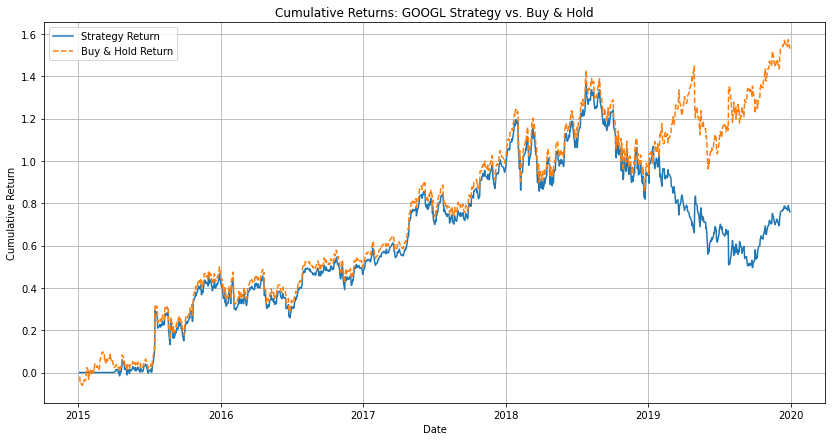

Performance Summary for GOOGL:
Cumulative Strategy Return: 75.92%
Cumulative Market Return: 152.99%
Sharpe Ratio: 60.27%
Sortino Ratio: 81.64%
Treynor Ratio: 11.68%
Max Drawdown: -37.04%
Tracking Error: 18.08%
Information Ratio: -40.98%


In [40]:
stocks = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
for stock in stocks:
    strategy = TradingStrategy(stock, '2015-01-01', '2019-12-31')
    strategy.calculate_indicators()
    strategy.generate_signals()
    strategy.calculate_returns()
    strategy.cumulative_return()
    strategy.sharpe_ratio()
    strategy.sortino_ratio()
    strategy.treynor_ratio(beta=1.2)  # Assuming beta = 1.2 for simplicity
    strategy.max_drawdown()
    strategy.tracking_error()
    strategy.information_ratio()
    strategy.visualize_signals()
    strategy.plot_cumulative_returns()
    strategy.summary()
